In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

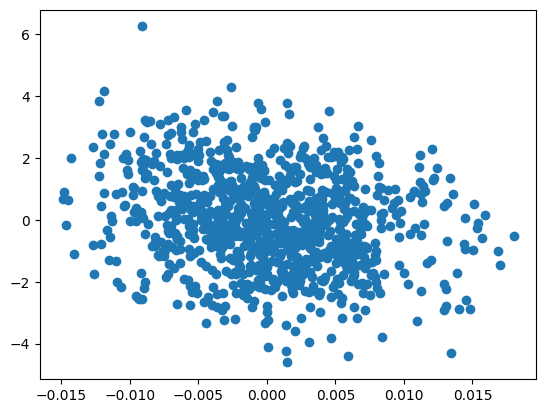

In [2]:
from sklearn.datasets import make_regression

seed = 23
n_samples = 1000
n_features = 100
n_output = 1

X, y = make_regression(
    n_samples=n_samples,
    n_features=n_features,
    n_targets=n_output,
    noise=1,
    effective_rank=2,
    random_state=seed
)

plt.scatter(X[:, 0], y)
plt.show()

In [7]:
class Net(nn.Module):
    def __init__(self, n_hidden=64, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )
    
    def forward(self, x):
        return self.layers(x)

model = Net()
model(torch.tensor(X[0], dtype=torch.float32))

tensor([0.0746], grad_fn=<ViewBackward0>)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [101]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

def make_train_test_loaders(X, y, batch_size=32):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed)

    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    X_test = torch.tensor(X_test, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test, dtype=torch.float32, device=device)

    data_train = list(zip(X_train, y_train))
    data_test = list(zip(X_test, y_test))

    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

train_loader, test_loader = make_train_test_loaders(X, y)

In [166]:
from tqdm import trange

criterion = nn.MSELoss()

def train_one_epoch(model, optimizer):
    model.train()
    track_loss = []

    for batch, labels in train_loader:
        batch, labels = batch.to(device), labels.to(device).unsqueeze(1) 

        optimizer.zero_grad()

        pred = model(batch)

        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        track_loss.append(loss.item())
    
    return np.mean(track_loss)

def train_model(model, optimizer, scheduler=None, n_epochs=100):
    train_history = []
    lr_history = []

    for _ in trange(n_epochs):
        loss_over_epoch = train_one_epoch(model, optimizer)
        train_history.append(loss_over_epoch)

        if scheduler is not None:
            scheduler.step()
            lr_history.append(scheduler.get_last_lr())
        
    return train_history if scheduler is None else train_history, lr_history


# Nesterov

In [118]:
from torch import optim

class SomeNesterov(optim.Optimizer):
    def __init__(self, params, lr=1e-3, momentum=0.9, weight_decay=0.0):
        defaults = dict(lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']
            momentum = group['momentum']

            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                
                if weight_decay:
                    grad = grad.add(param.data, alpha=weight_decay)

                param_state = self.state[param]
                if 'momentum_buffer' not in param_state:
                    buf = param_state['momentum_buffer'] = torch.clone(grad).detach()
                else:
                    buf = param_state['momentum_buffer']

                buf.mul_(momentum).add_(grad) # v_t
                grad = grad.add(buf, alpha=momentum) # theta~_t+1

                param.data.add_(grad, alpha=-lr) # theta_t+1


In [123]:
model = Net().to(device)

my_opt = SomeNesterov(model.parameters(), lr=1e-3, momentum=0.9)
my_loss = train_model(model, optimizer=my_opt)

100%|██████████| 100/100 [00:05<00:00, 17.04it/s]


In [124]:
model = Net().to(device)

torch_opt = optim.SGD(model.parameters(), nesterov=True, lr=1e-3, momentum=0.9)
torch_loss = train_model(model, optimizer=torch_opt)

100%|██████████| 100/100 [00:07<00:00, 13.44it/s]


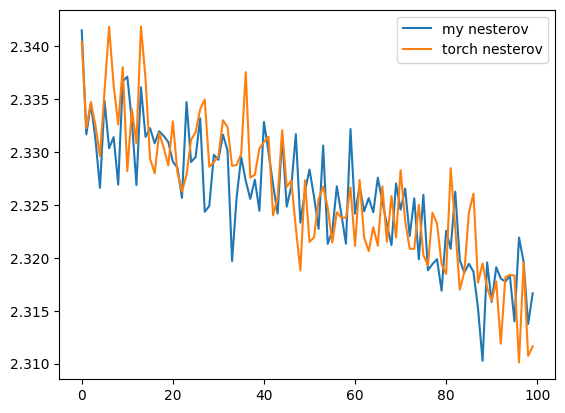

In [125]:
plt.plot(my_loss, label='my nesterov')
plt.plot(torch_loss, label='torch nesterov')
plt.legend()
plt.show()

# Adam

In [144]:
class SomeAdam(optim.Optimizer):
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']
            beta1, beta2 = group['betas']
            eps = group['eps']

            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                
                if weight_decay:
                    grad = grad.add(param.data, alpha=weight_decay)

                param_state = self.state[param]
                exp_avg = param_state.get(
                    'exp_avg', 
                    torch.zeros(param.data.shape, dtype=torch.float32, device=param.data.device)
                )
                exp_avg_sq = param_state.get(
                    'exp_avg_sq', 
                    torch.zeros(param.data.shape, dtype=torch.float32, device=param.data.device)
                )
                step_t = param_state.get(
                    'step', 
                    torch.zeros(1, dtype=torch.int64, device=param.data.device)
                )

                step_t += 1

                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                exp_avg_sq.mul_(beta2).add_(grad ** 2, alpha=1 - beta2)

                m_t = exp_avg.div(1 - beta1 ** step_t)
                v_t = exp_avg_sq.div(1 - beta2 ** step_t)

                denom = v_t.sqrt().add(eps)
                frac = m_t.div(denom)

                param.data.add_(frac, alpha=-lr)

In [150]:
model = Net().to(device)

my_opt = SomeAdam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
my_loss = train_model(model, optimizer=my_opt)

100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


In [151]:
model = Net().to(device)

torch_opt = optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8)
torch_loss = train_model(model, optimizer=torch_opt)

100%|██████████| 100/100 [00:06<00:00, 15.20it/s]


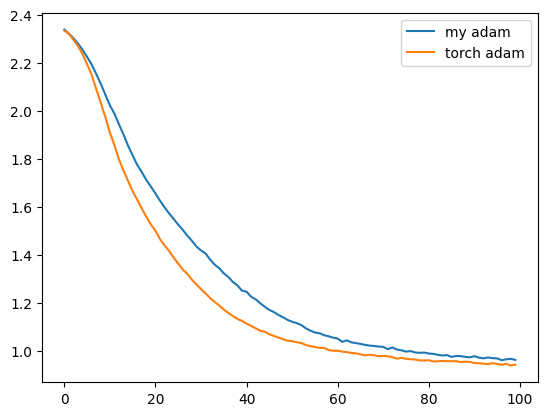

In [152]:
plt.plot(my_loss, label='my adam')
plt.plot(torch_loss, label='torch adam')
plt.legend()
plt.show()

# RMSprop

In [153]:
class SomeRMSprop(optim.Optimizer):
    def __init__(self, params, lr=1e-3, alpha=0.99, eps=1e-08, weight_decay=0.0):
        defaults = dict(lr=lr, alpha=alpha, eps=eps, weight_decay=weight_decay)
        super().__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            lr = group['lr']
            weight_decay = group['weight_decay']
            alpha = group['alpha']
            eps = group['eps']

            for param in group['params']:
                if param.grad is None:
                    continue
                
                grad = param.grad.data
                
                if weight_decay:
                    grad = grad.add(param.data, alpha=weight_decay)

                param_state = self.state[param]
                square_avg = param_state.get(
                    'square_avg', 
                    torch.zeros(param.data.shape, dtype=torch.float32, device=param.data.device)
                )

                square_avg.mul_(alpha).add_(grad ** 2, alpha=1 - alpha)
                denom = square_avg.sqrt().add(eps)
                frac = grad.div(denom)

                param.data.add_(frac, alpha=-lr)

In [157]:
model = Net().to(device)

my_opt = SomeRMSprop(model.parameters(), lr=1e-3, alpha=0.99, eps=1e-8)
my_loss = train_model(model, optimizer=my_opt)

100%|██████████| 100/100 [00:06<00:00, 15.29it/s]


In [158]:
model = Net().to(device)

torch_opt = optim.RMSprop(model.parameters(), lr=1e-3, alpha=0.99, eps=1e-8)
torch_loss = train_model(model, optimizer=torch_opt)

100%|██████████| 100/100 [00:06<00:00, 15.25it/s]


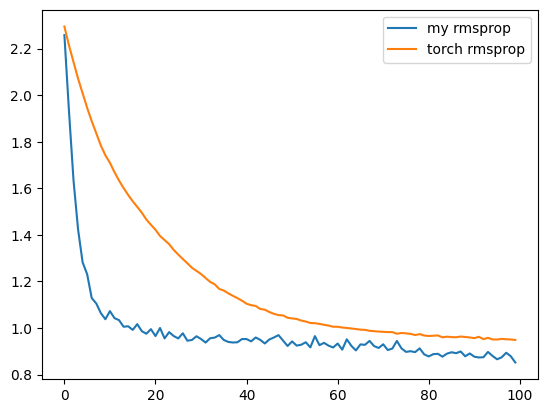

In [159]:
plt.plot(my_loss, label='my rmsprop')
plt.plot(torch_loss, label='torch rmsprop')
plt.legend()
plt.show()

# Schedulers

In [ ]:
class SomeStepLR(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1):
        self.step_size = step_size 
        self.gamma = gamma
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if (self.last_epoch == 0) or (self.last_epoch % self.step_size != 0):
            return [group["lr"] for group in self.optimizer.param_groups]
        return [group["lr"] * self.gamma for group in self.optimizer.param_groups]


class SomeExponentialLR(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, gamma=0.95, last_epoch=-1):
        self.gamma = gamma
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [base_lr * (self.gamma ** self.last_epoch) for base_lr in self.base_lrs]


In [191]:
def run_schedulers(optimizer_class):
    model = Net().to(device)

    opt = optimizer_class(model.parameters())
    step_scheduler = SomeStepLR(opt, step_size=10, gamma=0.1)

    step_loss, step_lrs = train_model(model, opt, step_scheduler)

    model = Net().to(device)

    opt = optimizer_class(model.parameters())
    exp_scheduler = SomeExponentialLR(opt, gamma=0.95)

    exp_loss, exp_lrs = train_model(model, opt, exp_scheduler)

    return step_loss, step_lrs, exp_loss, exp_lrs

In [192]:
step_loss, step_lrs, exp_loss, exp_lrs = run_schedulers(SomeNesterov)

100%|██████████| 100/100 [00:06<00:00, 16.18it/s]


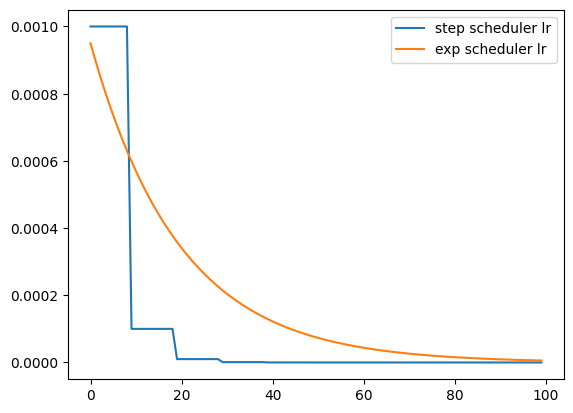

In [193]:
plt.plot(step_lrs, label='step scheduler lr')
plt.plot(exp_lrs, label='exp scheduler lr')
plt.legend()
plt.show()

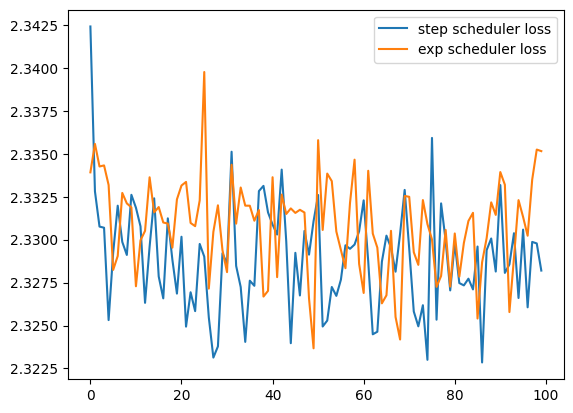

In [194]:
plt.plot(step_loss, label='step scheduler loss')
plt.plot(exp_loss, label='exp scheduler loss')
plt.legend()
plt.show()

In [195]:
step_loss, step_lrs, exp_loss, exp_lrs = run_schedulers(SomeAdam)

100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


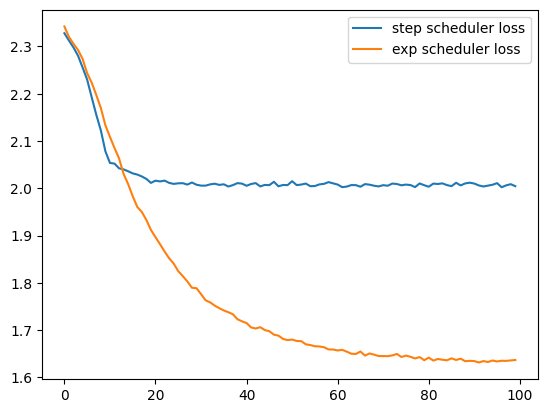

In [197]:
plt.plot(step_loss, label='step scheduler loss')
plt.plot(exp_loss, label='exp scheduler loss')
plt.legend()
plt.show()

In [198]:
step_loss, step_lrs, exp_loss, exp_lrs = run_schedulers(SomeRMSprop)

100%|██████████| 100/100 [00:09<00:00, 10.83it/s]


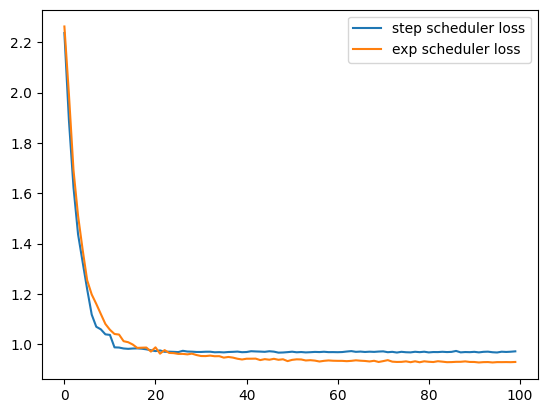

In [200]:
plt.plot(step_loss, label='step scheduler loss')
plt.plot(exp_loss, label='exp scheduler loss')
plt.legend()
plt.show()